In [107]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import torchio as tio
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from seaborn import heatmap


from functions import *

In [108]:
metaData = pd.read_csv('../metaDataTrain.csv') #remove 2 for GNB
metaDataClean = metaData.iloc
subject_list = load_training_dataset(metaDataClean)

## Let us construct the features vectors

In [109]:
features = np.zeros((100, 24))  #24 for GNB/RF

Let us add volume information to feature vectors

No need to use spacing info as volumes are normalized by sum of all volumes

In [110]:
volumes_1_ed = []
volumes_2_ed = []
volumes_3_ed = []

volumes_1_es = []
volumes_2_es = []
volumes_3_es = []

spacings = np.zeros((100))
   
for i in range(0, 100):
    subject = subject_list[i]
    
    ed_view = subject.ed_seg
    sum_volumes = get_volume(ed_view, 0) + get_volume(ed_view, 1) + get_volume(ed_view, 2) + get_volume(ed_view, 3)
    volumes_1_ed.append(get_volume(ed_view, 1)/sum_volumes)
    volumes_2_ed.append(get_volume(ed_view, 2)/sum_volumes)
    volumes_3_ed.append(get_volume(ed_view, 3)/sum_volumes)

    es_view = subject.es_seg
    sum_volumes = get_volume(es_view, 0) + get_volume(es_view, 1) + get_volume(es_view, 2) + get_volume(es_view, 3)
    volumes_1_es.append(get_volume(es_view, 1)/sum_volumes)
    volumes_2_es.append(get_volume(es_view, 2)/sum_volumes)
    volumes_3_es.append(get_volume(es_view, 3)/sum_volumes)

    spacings[i] = np.prod(subject.spacing)

volumes_1_ed = np.array([volumes_1_ed]).flatten() 
volumes_2_ed = np.array([volumes_2_ed]).flatten() 
volumes_3_ed = np.array([volumes_3_ed]).flatten() 

volumes_1_es = np.array([volumes_1_es]).flatten() 
volumes_2_es = np.array([volumes_2_es]).flatten() 
volumes_3_es = np.array([volumes_3_es]).flatten() 

######### new features
ejection_fraction_right = (volumes_1_ed - volumes_1_es) / volumes_1_ed
ejection_fraction_left = (volumes_3_ed - volumes_3_es) / volumes_3_ed


ratioRL_ed = volumes_3_ed / volumes_1_ed
ratioRL_es = volumes_3_es / volumes_1_es

ratioML_ed = volumes_2_ed / volumes_1_ed
ratioML_es = volumes_2_es / volumes_1_es


for i, new_col in enumerate([ratioRL_ed[:], ratioRL_es[:], ratioML_ed[:], ratioML_es[:], ejection_fraction_right[:], volumes_1_ed[:], volumes_2_ed[:], volumes_3_ed[:], ejection_fraction_left[:], volumes_1_es[:], volumes_2_es[:], volumes_3_es[:]]):
    features[:,i] = new_col

In [111]:
thicknesses = np.array(metaData.iloc[:, 4:])#*spacings[:, np.newaxis]
features[:,-12:] = thicknesses

In [112]:
mask = np.zeros(features.shape[1], dtype=bool)
#mask[[5, 6, 7, -1, -2, 0, 1, 2, 3, 9, 11, -3, -4, 4]] = True
mask[[5, 6, 7, -7, -8, 0, 1, 2, 3, 9, 11, -2, -1, 4]] = True #for gaussianNB good val

features = features[:, mask]

Let us just give our explicit class vector

In [113]:
classes = np.zeros((100))
classes[:20] = 2
classes[20:40] = 3
classes[40:60] = 1
classes[60:80] = 0
classes[80:100] = 4
classes = classes.astype('int')

First split and transform data

In [114]:
scaler_first = StandardScaler().fit(features)
features_scaled = scaler_first.transform(features)

features, classes, features_scaled = shuffle(features, classes, features_scaled, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(features_scaled, classes, test_size=0.25, stratify=classes)

In [115]:
clf = GaussianNB()

clf.fit(X_train, y_train)

GaussianNB()

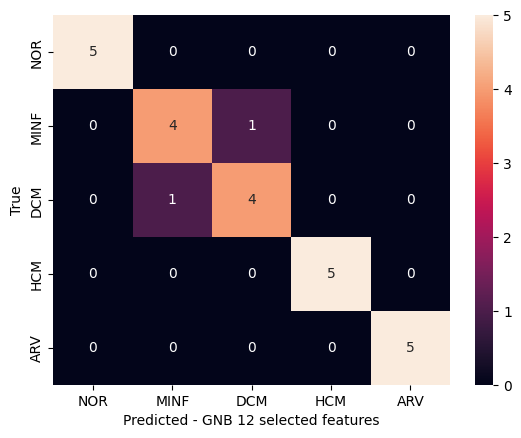

In [116]:
val_preds = clf.predict(X_val)

cm = confusion_matrix(y_val, val_preds, labels=[0,1,2,3,4])
heatmap(cm, annot=True, fmt='d', xticklabels=['NOR','MINF','DCM','HCM','ARV'], yticklabels=['NOR','MINF','DCM','HCM','ARV'])
plt.xlabel('Predicted - GNB 12 selected features')
plt.ylabel('True')
plt.show()

## Now let us test that model on the test dataset

In [83]:
test_features = np.zeros((50, 24))  

In [84]:
test_subject_list1 = load_filled_test_dataset()
test_subject_list = load_test_dataset()

volumes_1_ed = []
volumes_2_ed = []
volumes_3_ed = []

volumes_1_es = []
volumes_2_es = []
volumes_3_es = []

spacings_test = np.zeros((50))
   
for i in range(0, 50):
    subject1 = test_subject_list1[i]

    subject_ed = test_subject_list[i].ed_seg.data.numpy()[0]
    ed_view = subject1.ed_seg

    sum_volumes = get_volume(ed_view, 0) + get_volume(ed_view, 1) + get_volume(ed_view, 2) + int((lv_volume(subject_ed == 2)).sum())
    volumes_1_ed.append(get_volume(ed_view, 1)/sum_volumes)
    volumes_2_ed.append(get_volume(ed_view, 2)/sum_volumes)
    volumes_3_ed.append(int((lv_volume(subject_ed == 2)).sum())/sum_volumes)

    subject_es = test_subject_list[i].es_seg.data.numpy()[0]
    es_view = subject1.es_seg

    sum_volumes = get_volume(es_view, 0) + get_volume(es_view, 1) + get_volume(es_view, 2) + int((lv_volume(subject_es == 2)).sum())
    volumes_1_es.append(get_volume(es_view, 1)/sum_volumes)
    volumes_2_es.append(get_volume(es_view, 2)/sum_volumes)
    volumes_3_es.append(int((lv_volume(subject_es == 2)).sum())/sum_volumes)

    spacings[i] = subject.spacing[2]*subject.spacing[1]


volumes_1_ed = np.array([volumes_1_ed]).flatten()
volumes_2_ed = np.array([volumes_2_ed]).flatten()
volumes_3_ed = np.array([volumes_3_ed]).flatten()

volumes_1_es = np.array([volumes_1_es]).flatten()
volumes_2_es = np.array([volumes_2_es]).flatten()
volumes_3_es = np.array([volumes_3_es]).flatten()


ejection_fraction_right = (volumes_1_ed - volumes_1_es) / volumes_1_ed
ejection_fraction_left = (volumes_3_ed - volumes_3_es) / volumes_3_ed


ratioRL_ed = volumes_3_ed / volumes_1_ed
ratioRL_es = volumes_3_es / volumes_1_es

ratioML_ed = volumes_2_ed / volumes_1_ed
ratioML_es = volumes_2_es / volumes_1_es


for i, new_col in enumerate([ratioRL_ed[:], ratioRL_es[:], ratioML_ed[:], ratioML_es[:], ejection_fraction_right[:], volumes_1_ed[:], volumes_2_ed[:], volumes_3_ed[:], ejection_fraction_left[:], volumes_1_es[:], volumes_2_es[:], volumes_3_es[:]]):
    test_features[:,i] = new_col

In [85]:
metaDataTest = pd.read_csv('../metaDataTest.csv')

thicknesses_test = np.array(metaDataTest.iloc[:, 3:])#*spacings_test[:, np.newaxis]

test_features[:,-12:] = thicknesses_test

test_features = test_features[:, mask]
test_features_scaled = scaler_first.transform(test_features)

We can now predict

In [86]:
test_preds = clf.predict(test_features_scaled)

And write down for submission

In [500]:
test_preds

array([2, 4, 0, 3, 4, 1, 0, 0, 4, 4, 3, 3, 0, 0, 0, 4, 2, 3, 1, 0, 4, 0,
       3, 3, 1, 2, 1, 4, 2, 4, 1, 4, 3, 2, 0, 3, 2, 3, 1, 0, 2, 1, 2, 2,
       4, 2, 0, 1, 1, 1])

In [501]:
df = pd.read_csv("../SampleSubmission.csv")
df.iloc[:, 1] = test_preds
df.to_csv("../SampleSubmission.csv", index=False)